# Basic usage

This example demonstrates the basic usage of combined TFRs and how to compute and plot them using the ctfr package.

In [1]:
import ctfr
import numpy as np
import matplotlib.pyplot as plt

---

### Loading the audio data

Our synthetic example consists of $1$ s of audio data sampled at $22050 Hz$. The signal is comprised of two superposed sinusoidal components with frequencies $f_1 = 440$ Hz and $f_2 = 506$ Hz, as well as a pulse component with a short duration around $t = 0.5$ s. We will see how the ctfr package can help us compute a combined TFR of STFTs with good resolution in both time and frequency domains, which is not possible with a traditional STFT. Let's load the audio data and plot it.

Sample rate: 22050 Hz


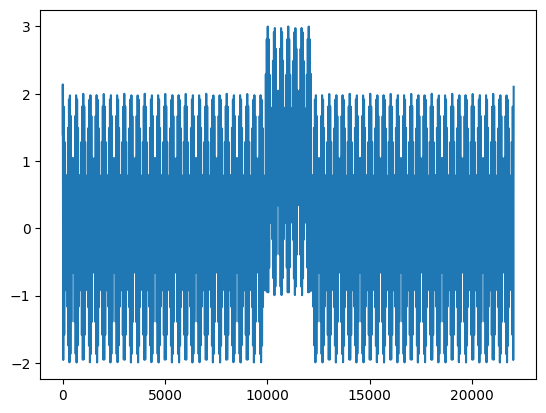

In [2]:
# Load the audio signal.
signal, sr = ctfr.load(ctfr.fetch_sample("synthetic"), sr=22050) # For a local file, use ctfr.load("path/to/file")
print(f"Sample rate: {sr} Hz")
plt.plot(signal);

---

### Computing STFT spectrograms with different resolutions.

Now, let's compute and plot an STFT spectrogram of the audio signal. We will use a window length of $L = 512$ samples (approximately $23$ ms), a hop length of $512$ samples, and a FFT size of $2048$ samples.

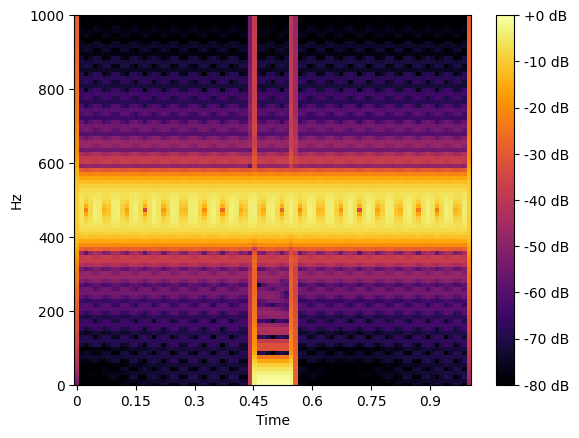

In [3]:
# Compute the spectrogram with L = 512.
spec_512 = ctfr.stft_spec(signal, win_length=512, n_fft=2048, hop_length=256)

# Plot the spectrogram.
img = ctfr.specshow(ctfr.power_to_db(spec_512, ref=np.max), sr=sr, hop_length=256, x_axis="time", y_axis="linear", cmap="inferno")
plt.ylim(0, 1000)
plt.colorbar(img, format="%+2.0f dB");

We can see that the the pulse component's onset and offset are well delineated, but the sinusoidal components are not well resolved in the frequency domain. This is due to the short window length, which provides good time resolution but poor frequency resolution.

Now, let's increase the window length to $L = 1024$ samples (~ $46$ ms) and plot the STFT spectrogram again.

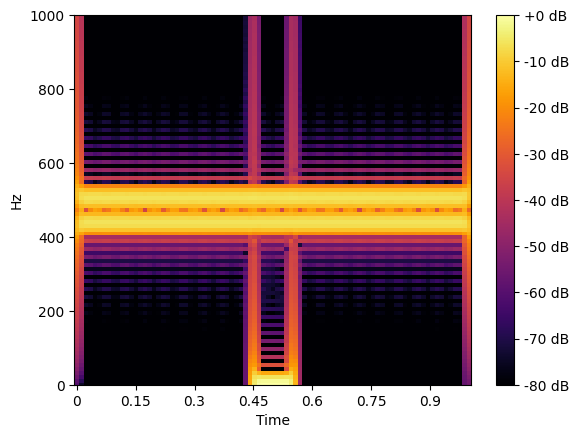

In [4]:
# Compute the spectrogram with L = 1024.
spec_1024 = ctfr.stft_spec(signal, win_length=1024, n_fft=2048, hop_length=256)

# Plot the spectrogram.
img = ctfr.specshow(ctfr.power_to_db(spec_1024, ref=np.max), sr=sr, hop_length=256, x_axis="time", y_axis="linear", cmap="inferno")
plt.ylim(0, 1000)
plt.colorbar(img, format="%+2.0f dB");

We can see that our frequency resolution is improved at the cost of poorer time resolution.

Let's go even further and increase our window length to $L = 2048$ samples (~ $93$ ms), compute the corresponding STFT and plot the resulting spectrogram.

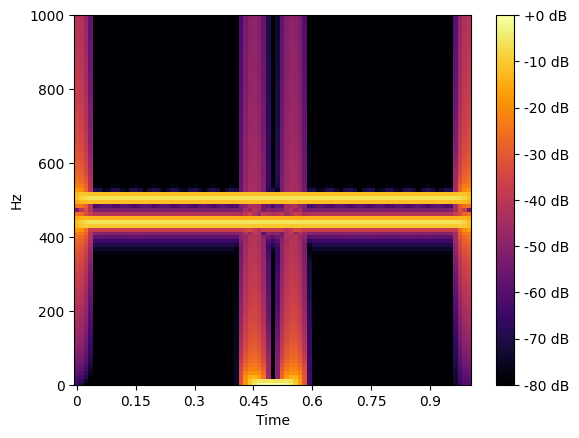

In [5]:
# Compute the spectrogram with L = 2048.
spec_2048 = ctfr.stft_spec(signal, win_length=2048, n_fft=2048, hop_length=256)

# Plot the spectrogram.
img = ctfr.specshow(ctfr.power_to_db(spec_2048, ref=np.max), sr=sr, hop_length=256, x_axis="time", y_axis="linear", cmap="inferno")
plt.ylim(0, 1000)
plt.colorbar(img, format="%+2.0f dB");

With this larger window length, our sinusoidal components are now well resolved in the frequency domain, but the pulse component's onset and offset are not well delineated.

----

### Computing a combined TFR

In summary, what we have seen is the time-frequency trade-off. Achieving better frequency resolution (by increasing the window length) comes at the cost of poorer time resolution, and vice versa. However, we can circumvent this problem by computing a combined TFR, which is an average (in a generalized sense) of multiple STFTs computed with different window lengths. This allows us to achieve good resolution in both time and frequency domains.

Let's see how we can do this using the package.

#### Using ctfr.ctfr_from_specs

Since we have already computed  STFTs with different window lengths, we can use the ```ctfr_from_specs``` function to compute a combined TFR from these STFT spectrograms. This function requires an iterable of STFT spectrograms with the same time-frequency alignment. Since we used the same hop length and FFT size for all STFTs, they are already aligned.

In [6]:
print(spec_512.shape)
print(spec_1024.shape)
print(spec_2048.shape)

(1025, 87)
(1025, 87)
(1025, 87)


We also have to provide a combination method. Let's list all available methods:

In [7]:
ctfr.show_methods()

Available combination methods:
- Binwise mean -- mean
- Binwise harmonic mean -- hmean
- Binwise geometric mean -- gmean
- Binwise minimum -- min
- Sample-weighted geometric mean (SWGM) -- swgm
- Fast local sparsity (FLS) -- fls
- Lukin-Todd (LT) -- lt
- Hybrid smoothed local sparsity (SLS-H) -- sls_h
- Smoothed local sparsity with interpolation (SLS-I) -- sls_i


For this example, we'll use the Sample-Weighted Geometric Mean (SWGM), which is a lightweight and effective binwise combination method. Let's compute the combined TFR and plot it.

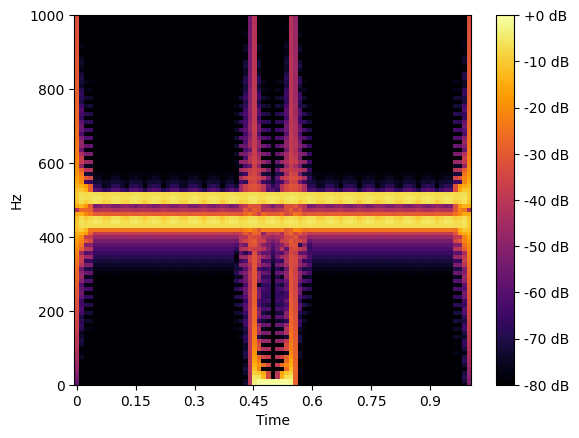

In [8]:
# Compute the combined spectrogram using ctfr.ctfr_from_specs and the SWGM method,
swgm_spec = ctfr.ctfr_from_specs((spec_512, spec_1024, spec_2048), method="swgm")

# Plot the combined spectrogram.
img = ctfr.specshow(ctfr.power_to_db(swgm_spec, ref=np.max), sr=sr, hop_length=256, x_axis="time", y_axis="linear", cmap="inferno")
plt.ylim(0, 1000)
plt.colorbar(img, format="%+2.0f dB");

> **_Note:_**  You can also use ```ctfr.methods.swgm_from_specs(X, ...)```, which is an alias for ```ctfr.ctfr_from_specs(X, method="swgm", ...)```.

As we can see, we have achieved good resolution in both time and frequency domains, with the sinusoidal components and the pulse component well resolved.

----

#### Using ctfr.ctfr

Using ```ctfr_from_specs``` is useful when we already have the STFT spectrograms to combine, or when we want more control over how to generate them. When we just want to compute a combined TFR directly from an audio signal, we can use the ```ctfr``` function, which computes the STFT spectrograms with different window lengths and then combines them.

Let's do this for our signal, using the same parameters as before.

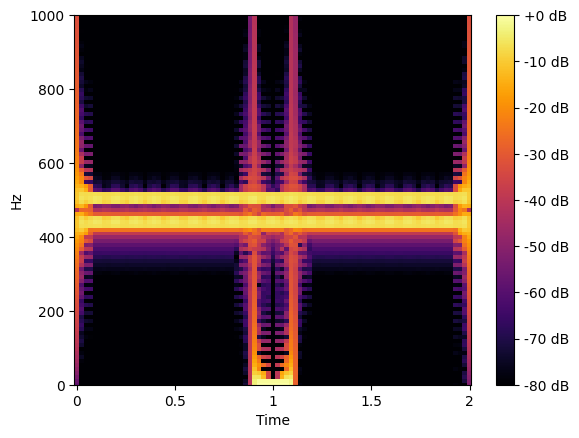

In [9]:
# Compute the combined spectrogram using ctfr.ctfr and the SWGM method,
swgm_spec_2 = ctfr.ctfr(signal, sr = sr, method = "swgm", win_lengths=[512, 1024, 2048], hop_length=256, n_fft=2048)

# Plot the combined spectrogram.
img = ctfr.specshow(ctfr.power_to_db(swgm_spec_2, ref=np.max), sr=sr, hop_length=512, x_axis="time", y_axis="linear", cmap="inferno")
plt.ylim(0, 1000)
plt.colorbar(img, format="%+2.0f dB");

> **_Note:_** You can also use ```ctfr.methods.swgm(X, sr, ...)```, which is an alias for ```ctfr.ctfr(X, sr, method="swgm", ...)```.

We can see that the combined spectrogram looks the same as the one we computed in the previous section. Let's confirm that they're indeed the same:

In [10]:
np.array_equal(swgm_spec, swgm_spec_2)

True